#Simple

Poenta ovog Notebooka je testirati običan "školski" model: Konvolutivni i agregirajući slojevi isprepletani, i na kraju gust sloj.

In [1]:
import numpy as np
from PIL import Image
import os

In [2]:
data_dir = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/scaled"

In [3]:
def load_images_to_numpy(src_path: str) -> np.ndarray:
    res = os.listdir(src_path)
    res = map(lambda path: os.path.join(src_path, path), res)
    res = map(Image.open, res)
    res = map(np.asarray, res)
    res = np.stack([*res], axis=0)
    return res

def load_images(src_path: str):
    X_false = load_images_to_numpy(os.path.join(src_path, "NORMAL"))
    y_false = np.zeros((X_false.shape[0],), dtype=np.uint8)

    X_true = load_images_to_numpy(os.path.join(src_path, "PNEUMONIA"))
    y_true = np.ones((X_true.shape[0],), dtype=np.uint8)

    X = np.concatenate([X_false, X_true])
    y = np.concatenate([y_false, y_true])
    return (X, y)

X, y = load_images(os.path.join(data_dir, "train"))

In [4]:
X.shape, y.shape

((5216, 280, 400), (5216,))

Treba podeliti skup na trening i test skup.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [7]:
X_train.shape, y_train.shape

((4694, 280, 400), (4694,))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Reshape

In [9]:
def make_model(shape, activation, **kwargs):
    model = Sequential()
    model.add(InputLayer(shape))
    model.add(Reshape((shape[0], shape[1], 1)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation=activation))
    model.compile(**kwargs)
    return model

In [20]:
model = make_model(
    shape=(X_train.shape[1], X_train.shape[2]),
    activation='sigmoid',
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 280, 400, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 278, 398, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 139, 199, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 137, 197, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 68, 98, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 66, 96, 64)       

Ovako postavljen model ima 12 miliona parametara. Najveći broj parametara nalazi se u gustom sloju dok je broj parametara za učenje u ostalim slojevima zanemarljiv.

Da bi se izbeglo nagađanje broja epohi, koristi se `ModelCheckpoint` da sačuva svaki model u svakoj epohi koji se napravi. Ovaj put ću ručno birati najbolji model, a ubuduće ću koristiti njegovu ugrađenu funkcionalnost da sačuvava samo model koji ima najbolju odabranu metriku.

Svi generisani modeli nalaze se na putanji `/content/drive/MyDrive/MasinskoUcenjeChestXRay/models/simple/checkpoint` gde je ime svakog modela epoha u kojoj je nastao, a najbolji model čuvaću na putanji `/content/drive/MyDrive/MasinskoUcenjeChestXRay/models/simple/model.h5`.

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [18]:
model_path = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/models/simple"
if not os.path.isdir(model_path):
        os.makedirs(model_path)
model_checkpoints_path = os.path.join(model_path, "checkpoint")
if not os.path.isdir(model_checkpoints_path):
        os.makedirs(model_checkpoints_path)

In [23]:
history = model.fit(
    X_train, y_train,
    verbose=0,
    epochs=50,
    validation_split=0.1,
    callbacks=[ModelCheckpoint(filepath=os.path.join(model_checkpoints_path, "{epoch:02d}.h5"))]
)

In [24]:
from matplotlib import pyplot as plt

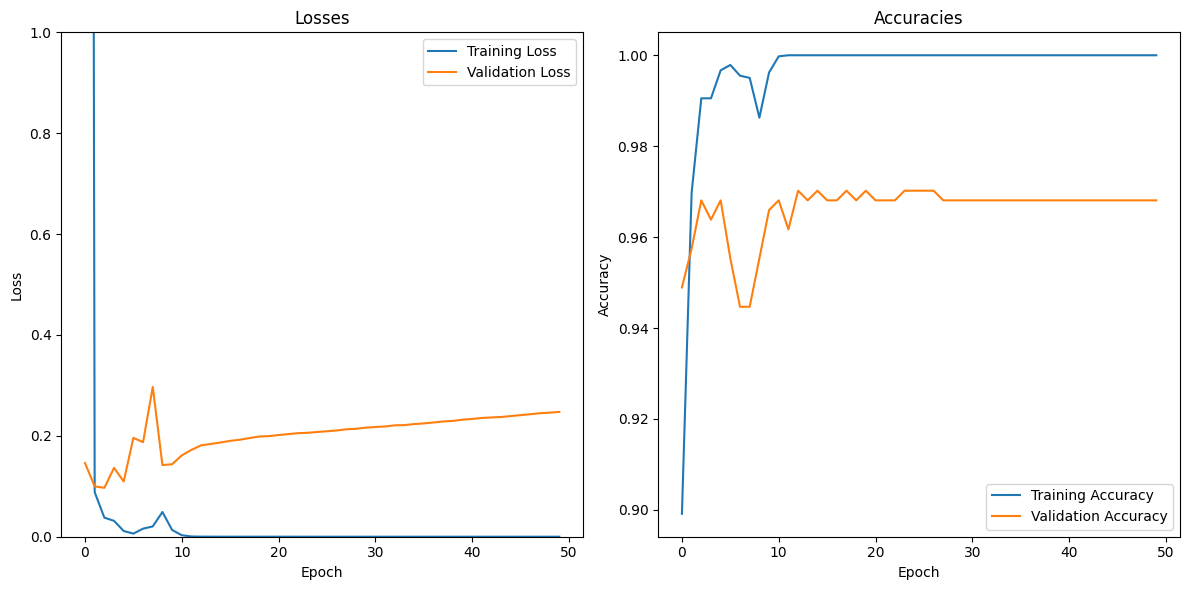

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Zbog preprilagođavanja, iako loss na trening podacima opada, na validacionom krene da raste. Modele posle epohe 10 ne vredi gledati jer je pretpostavka da loše generalizuju. Model sa najboljim lossom je model epohe 3, ali se posle toga vidi model sa mizerno lošijim lossom ali sa mnogo boljom preciznošću. Najbolji model za odabir je model epohe 5, sve posle toga je preprilagođeno.

In [29]:
from tensorflow.keras.models import load_model

In [30]:
best_model_no = np.argmin(history.history['val_loss']) + 1
second_best_model_no = np.argmin(history.history['val_loss'][best_model_no:]) + best_model_no + 1
print(f"Best model: {best_model_no:02d}; Second best model: {second_best_model_no:02d}")

best_model = load_model(os.path.join(model_checkpoints_path, f"{best_model_no:02d}.h5"))
second_best_model = load_model(os.path.join(model_checkpoints_path, f"{second_best_model_no:02d}.h5"))

Best model: 03; Second best model: 05


In [31]:
y_pred_1 = best_model.predict(X_test)
y_pred_1 = np.where(y_pred_1 < 0.5, 0, 1)

y_pred_2 = second_best_model.predict(X_test)
y_pred_2 = np.where(y_pred_2 < 0.5, 0, 1)

17/17 [==============================] - 0s 4ms/step


In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [35]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       134
           1       0.98      0.97      0.98       388

    accuracy                           0.97       522
   macro avg       0.95      0.96      0.96       522
weighted avg       0.97      0.97      0.97       522



In [36]:
pd.DataFrame(confusion_matrix(y_test, y_pred_1), index=["NORMAL", "PNEUMONIA"], columns=["NORMAL", "PNEUMONIA"])

,NORMAL,PNEUMONIA
NORMAL,127,7
PNEUMONIA,11,377


In [37]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       134
           1       0.98      0.99      0.98       388

    accuracy                           0.98       522
   macro avg       0.97      0.96      0.97       522
weighted avg       0.98      0.98      0.98       522



In [38]:
pd.DataFrame(confusion_matrix(y_test, y_pred_2), index=["NORMAL", "PNEUMONIA"], columns=["NORMAL", "PNEUMONIA"])

,NORMAL,PNEUMONIA
NORMAL,126,8
PNEUMONIA,4,384


Drugi model blago bolje radi, mada u oba veoma malo greši. U oba slučaja je odziv zdravih blago lošiji.

Sačuvaću drugi model.

In [39]:
second_best_model.save(os.path.join(model_path, "model.h5"))